> **Best algorithm comparison** \
> Comparison between TD3, SAC, and DSAC when controlling a LTI aircraft to track a sinusoidal pitch rate reference

# ⚙️ Set-up
Load required packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from helpers.paths import Path
from visualization.utils import make_smooth

sns.set()

Load a dataframe that contains the information from the algorithm's learning performance and a dataframe that contains the data from runing episodes with the learned agents

In [2]:
df_learn = pd.read_csv(Path.data/"best_algo_learning.csv")
df_ep = pd.read_csv(Path.data/"best_algo_episode.csv")

## Data checks

Number of unique learning for each algorithm

In [3]:
df_learn.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    25
SAC     25
TD3     25
dtype: int64

In [4]:
df_ep.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    25
SAC     25
TD3     25
dtype: int64

In [5]:
algorithm = "DSAC"
df_ep_rew = df_ep.groupby(["run", "algorithm"])["reward"].sum().reset_index()
reward_count = df_ep_rew[df_ep_rew.algorithm==algorithm]["reward"].value_counts()
duplicated_rewards = reward_count[reward_count>1].index.values

df_ep_rew[df_ep_rew.reward.isin(duplicated_rewards)].groupby(["reward", "run"]).count()

,,algorithm
reward,run,


## Data treatment

Define function that smooths data

Smooth learning data

In [6]:
df_learn_smooth = make_smooth(df_learn, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm"])

# 👨🏽‍🏫 Learning performance

Each of the three algorithms were trained in 30 different random seeds. The results of the mean return and the episode length through the learning steps are shown bellow:

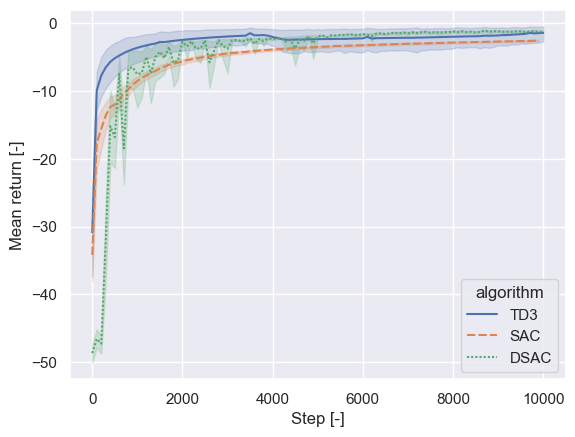

In [7]:
g = sns.lineplot(data=df_learn_smooth, x="global_step", y="rollout/ep_rew_mean", hue="algorithm", style="algorithm")
g.set(xlabel="Step [-]", ylabel="Mean return [-]");

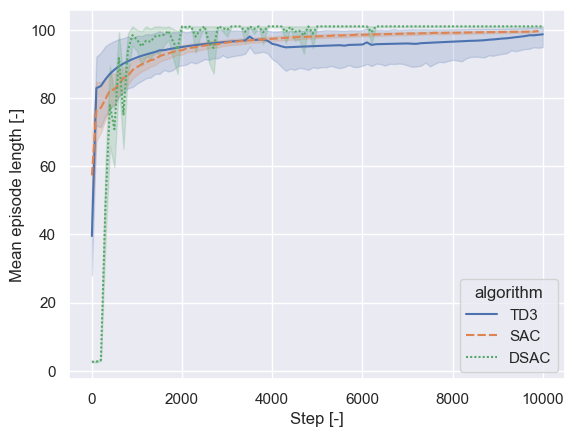

In [8]:
g = sns.lineplot(data=df_learn_smooth, x="global_step", y="rollout/ep_len_mean", hue="algorithm", style="algorithm")
g.set(xlabel="Step [-]", ylabel="Mean episode length [-]");

DSAC is the algorithm that, in average, reaches the highest return. SAC comes second, followed by TD3. In the first learning steps, TD3 and SAC lead in performance by having a quick rise in return. DSAC on the other hand, shows a longer rising time, only reaching the same performance of the other algorithms after approximatly 1000 steps. Overall, DSAC and SAC achive comparable performance. SAC with the advantage of having a quicker rise. However, it is important to reacall that those algorithms are intended to be part of the offline-trained part of the flight controller. In an offline setting, the  maximum return and consistency have a higher importance then learning quickly. This however, is not the case for the online-trained part, where the algorithm shall learn as quick as possible to adapt to the environment. 


A single episode in the studied tracking task ends after 100 steps. However, if the aircraft states is outside their acceptable range, the episode is terminated. The episode length plot shows that SAC and DSAC are consistent in learning to control the aircraft through the 100 steps. For the episodes of the TD3 agent, the average length of the episode is 85 steps. Therefore, this algorithm is not consistent in learning, where for some seeds it does not learn to control the aircraft through the entire episode length. The consistency of SAC and TD3 is also demosntraded by the low variance they exhibit, which is not the case for TD3.

# Episode analysis

In [9]:
df_ep_run = df_ep.groupby(["run", "algorithm"])[["reward", "tracking_error"]].sum().reset_index()

In [10]:
df_ep.groupby(["run", "algorithm"])["episode_step"].count().describe()

count     75.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: episode_step, dtype: float64

In [11]:
df_ep_run[df_ep_run.algorithm=="SAC"]["tracking_error"]

0     0.191402
3     0.227838
4     0.076736
13    0.604612
15    0.256143
16    0.482085
19    0.566952
22    0.432805
24    0.251123
26    0.466819
27    0.775802
28    0.337541
35    0.568947
41    0.048950
42    0.185163
45    0.331795
48    0.559788
55    0.603200
56    1.136347
58    0.040742
61    0.150367
65    1.400885
67    1.364825
69    0.312754
72    0.904453
Name: tracking_error, dtype: float64

<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

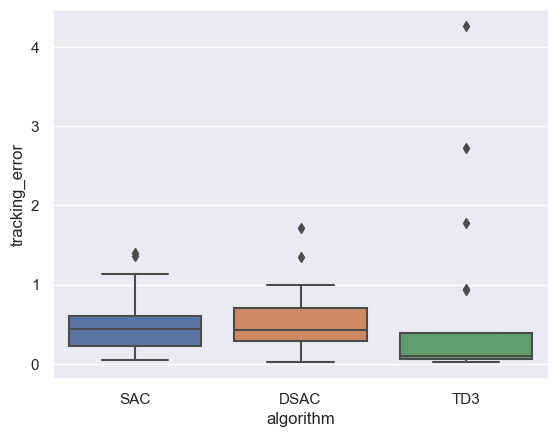

In [43]:
sns.boxplot(data=df_ep_run, x="algorithm", y="tracking_error")

In [41]:
df_ep_run

,reward,tracking_error
count,75.000000,75.000000
mean,-0.506760,0.506760
std,0.656672,0.656672
min,-4.264213,0.015622
25%,-0.603906,0.099769
50%,-0.312754,0.312754
75%,-0.099769,0.603906
max,-0.015622,4.264213


In [22]:
df_ep.groupby(["run", "algorithm"])["tracking_error"].sum().sort_values()

# sns.relplot(data=df_ep, x="episode_step", y="state", col="algorithm",  kind="line")

run                   algorithm
ruby-puddle-140       TD3          0.015622
sunny-butterfly-71    DSAC         0.019797
zany-universe-6       TD3          0.024454
helpful-dragon-69     TD3          0.026217
clear-violet-15       TD3          0.032104
                                     ...   
upbeat-armadillo-132  SAC          1.400885
genial-monkey-130     DSAC         1.710015
glowing-frog-131      TD3          1.772839
true-sun-81           TD3          2.725911
comfy-pond-18         TD3          4.264213
Name: tracking_error, Length: 75, dtype: float64

<AxesSubplot: xlabel='episode_step', ylabel='state'>

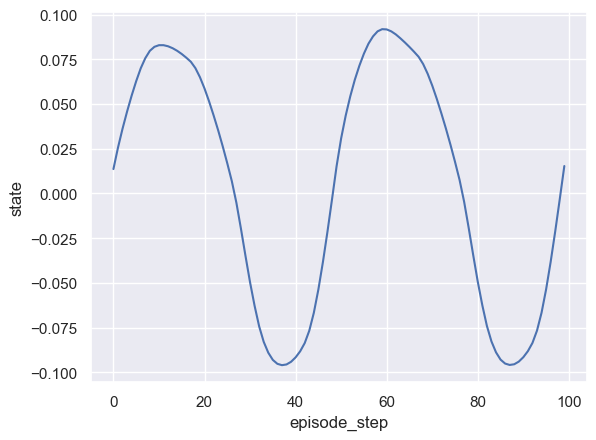

In [25]:
sns.lineplot(data=df_ep[df_ep.run=="sunny-butterfly-71"], x="episode_step", y="state")

In [34]:
df_ep_run.groupby(["run", "algorithm"])["tracking_error"].sum().reset_index().groupby("algorithm").mean()

/var/folders/kz/2zydzyyx1nn9y3bf433qq35c0000gn/T/ipykernel_61884/2240044081.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ep_run.groupby(["run", "algorithm"])["tracking_error"].sum().reset_index().groupby("algorithm").mean()


,tracking_error
algorithm,
DSAC,0.514278
SAC,0.491123
TD3,0.514879


In [35]:
df_ep.groupby("algorithm").mean()


/var/folders/kz/2zydzyyx1nn9y3bf433qq35c0000gn/T/ipykernel_61884/3000482778.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ep.groupby("algorithm").mean()


,Unnamed: 0,episode_step,tracking_error,state,reference,reward,action
algorithm,,,,,,,
DSAC,49.5,49.5,0.005143,-0.046575,-2.636838e-17,-0.005143,0.020376
SAC,49.5,49.5,0.004911,0.035036,-2.636838e-17,-0.004911,-0.017710
TD3,49.5,49.5,0.005149,-0.026287,-2.636838e-17,-0.005149,0.011583
